# HR Attrition Analysis in Python 

**Goal:** Use exploratory data analysis (EDA) and simple, explainable models to understand **who leaves** and **why**, using the `HR_comma_sep.csv` dataset.

---

## What you'll learn
- How to **audit** a dataset (schema, missing values, duplicates)
- Why **rates** matter more than raw counts (e.g., attrition by department)
- How to handle common pandas/seaborn pitfalls (e.g., `.corr()` with strings, deprecated `distplot`)
- How to build a clean scikit-learn **pipeline** (preprocessing + model)
- How to translate findings into **actionable HR recommendations**

## Notes & caveats
- This is a **training dataset** with unusually clean and strong signals; real HR data tends to be noisier.
- **Correlation ≠ causation.** We use these results to generate hypotheses and prioritize follow-ups.
- Use any predictive model for **support and triage**, not automated employment decisions.


In [31]:
# Core stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)

from IPython.display import display


## 1) Load the data

The raw file uses two column names that are easy to misread:
- `sales` is actually the **department**
- `average_montly_hours` has a spelling typo (should be `average_monthly_hours`)

We'll load the file first, then clean names in the next step.


In [32]:
df_raw = pd.read_csv("HR_comma_sep.csv")
df_raw.shape

(14999, 10)

In [33]:
df_raw.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2) Quick data audit (missing values, types, duplicates)

Before plotting anything, validate:
- Data types (numeric vs categorical)
- Missing values
- Duplicate rows (this dataset has a surprisingly large number of exact duplicates)

Duplicates can materially change:
- observed attrition rate
- model performance
- group comparisons


In [34]:
# Missing values
missing = df_raw.isna().sum().sort_values(ascending=False)

# Data types
dtypes = df_raw.dtypes

# Exact duplicates
dup_count = df_raw.duplicated().sum()
dup_pct = dup_count / len(df_raw)

# Baseline attrition rate (raw)
raw_attrition = df_raw["left"].mean()

missing, dtypes, dup_count, dup_pct, raw_attrition

(satisfaction_level       0
 last_evaluation          0
 number_project           0
 average_montly_hours     0
 time_spend_company       0
 Work_accident            0
 left                     0
 promotion_last_5years    0
 sales                    0
 salary                   0
 dtype: int64,
 satisfaction_level       float64
 last_evaluation          float64
 number_project             int64
 average_montly_hours       int64
 time_spend_company         int64
 Work_accident              int64
 left                       int64
 promotion_last_5years      int64
 sales                     object
 salary                    object
 dtype: object,
 np.int64(3008),
 np.float64(0.2005467031135409),
 np.float64(0.2380825388359224))

## 3) Cleaning improvements

### 3.1 Rename columns for clarity
We make the dataset easier to reason about by renaming:
- `sales` → `department`
- `average_montly_hours` → `average_monthly_hours`

### 3.2 Make categorical columns explicit
- `department`: category
- `salary`: ordered category (`low` < `medium` < `high`)

### 3.3 Remove exact duplicates
This dataset contains many exact duplicate rows (≈20%).  
After removing duplicates, the *overall attrition rate drops significantly*, which is why this step is included in the “improved” workflow.


In [35]:
df = df_raw.rename(columns={
    "sales": "department",
    "average_montly_hours": "average_monthly_hours",
}).copy()

df["department"] = df["department"].astype("category")
df["salary"] = pd.Categorical(
    df["salary"],
    categories=["low", "medium", "high"],
    ordered=True
)

# Compare attrition before/after dropping exact duplicates
df_dedup = df.drop_duplicates().reset_index(drop=True)

raw_rate = df["left"].mean()
dedup_rate = df_dedup["left"].mean()

df.shape, df_dedup.shape, raw_rate, dedup_rate

((14999, 10),
 (11991, 10),
 np.float64(0.2380825388359224),
 np.float64(0.1660411975648403))

From this point forward, we will continue with the **deduplicated** dataset (`df`).

In [36]:
df = df_dedup
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 4) EDA: Baseline attrition and group-level rates

A common early pitfall is plotting **raw counts** of leavers by department.  
Counts can be misleading because departments have different headcounts.

Instead, we start with **attrition rate**:
- `attrition_rate = mean(left)` because `left` is 0/1


In [37]:
overall_attrition = df["left"].mean()
overall_attrition

np.float64(0.1660411975648403)

### 4.1 Attrition rate by salary

This is often one of the clearest segment-level signals.  
We compute rates first, then plot.


In [38]:
salary_rate = (
    df.groupby("salary", observed=True)["left"]
      .mean()
      .sort_index()
)

salary_rate

salary
low       0.204530
medium    0.146170
high      0.048485
Name: left, dtype: float64

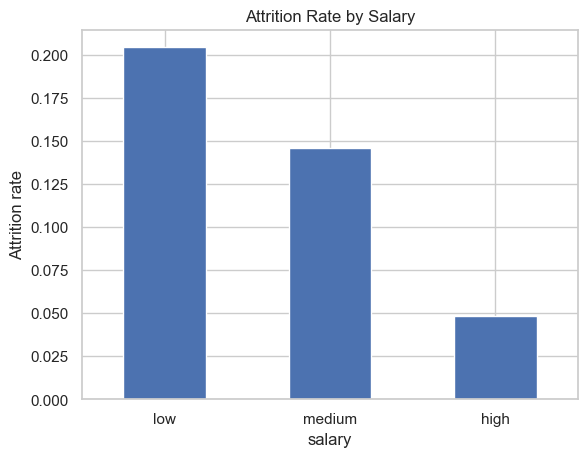

In [39]:
ax = salary_rate.plot(kind="bar")
ax.set_ylabel("Attrition rate")
ax.set_title("Attrition Rate by Salary")
plt.xticks(rotation=0)
plt.show()

### 4.2 Attrition rate by department

Again: use **rate** (mean of `left`), not raw counts.


In [40]:
dept_rate = (
    df.groupby("department", observed=True)["left"]
      .mean()
      .sort_values(ascending=False)
)

dept_rate

department
hr             0.188020
accounting     0.175523
technical      0.173797
support        0.171334
sales          0.169805
marketing      0.166419
IT             0.161885
product_mng    0.160350
RandD          0.122478
management     0.119266
Name: left, dtype: float64

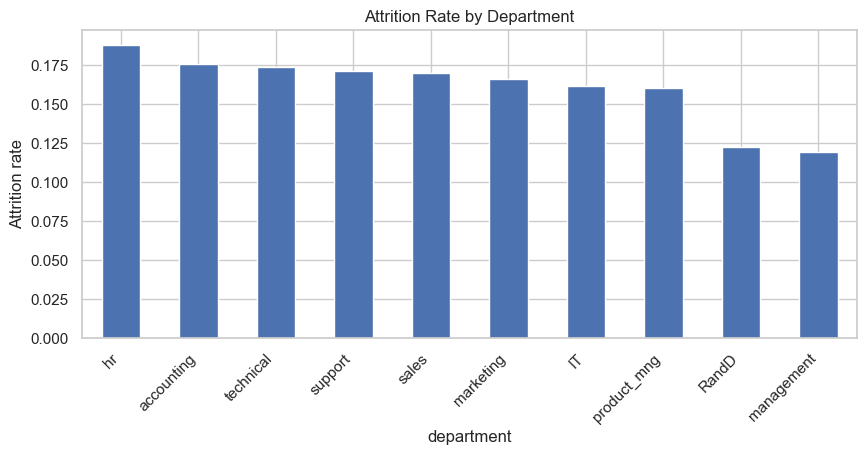

In [11]:
plt.figure(figsize=(10, 4))
ax = dept_rate.plot(kind="bar")
ax.set_ylabel("Attrition rate")
ax.set_title("Attrition Rate by Department")
plt.xticks(rotation=45, ha="right")
plt.show()

## 5) Satisfaction: distribution and relationship with attrition

Seaborn’s `distplot()` is deprecated, so we use:
- `sns.histplot(..., kde=True)` for a histogram + density curve
- Split by `left` to see separation between leavers and stayers


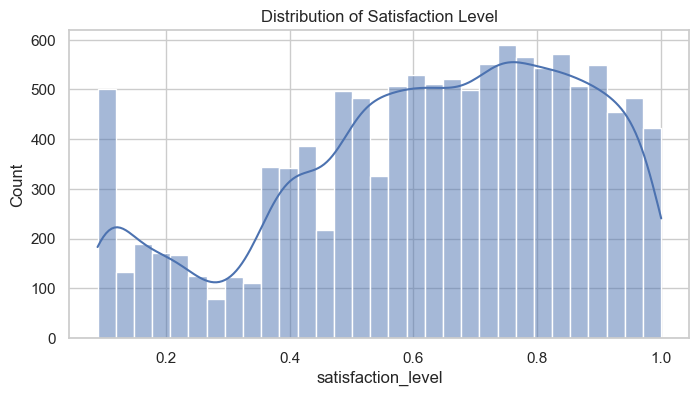

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df["satisfaction_level"], kde=True)
plt.title("Distribution of Satisfaction Level")
plt.show()

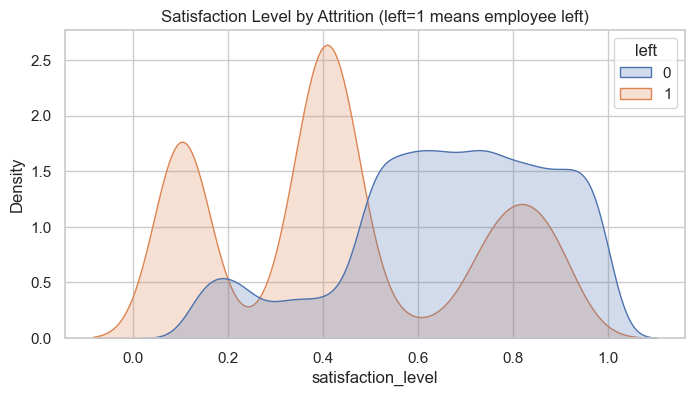

In [13]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df, x="satisfaction_level", hue="left", fill=True, common_norm=False)
plt.title("Satisfaction Level by Attrition (left=1 means employee left)")
plt.show()

## 6) Workload patterns: projects and hours

In this dataset, attrition risk is **non-linear** with respect to `number_project`.
Averages can hide this: employees with very low project load and very high project load both show elevated attrition.

Let's compute attrition by project count and include sample sizes.


In [14]:
proj_summary = (
    df.groupby("number_project")["left"]
      .agg(attrition_rate="mean", n="size")
      .reset_index()
)

proj_summary

,number_project,attrition_rate,n
0,2,0.541719,1582
1,3,0.010795,3520
2,4,0.064315,3685
3,5,0.153605,2233
4,6,0.449153,826
5,7,1.000000,145


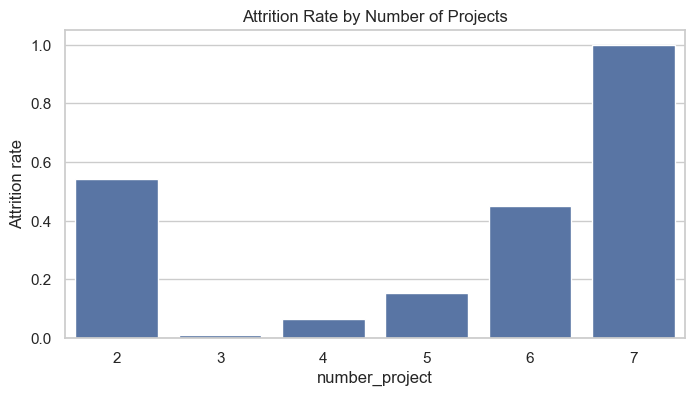

In [15]:
plt.figure(figsize=(8, 4))
sns.barplot(data=proj_summary, x="number_project", y="attrition_rate")
plt.title("Attrition Rate by Number of Projects")
plt.ylabel("Attrition rate")
plt.show()

### 6.1 Monthly hours vs attrition

We'll also look at how `average_monthly_hours` differs between leavers and stayers.


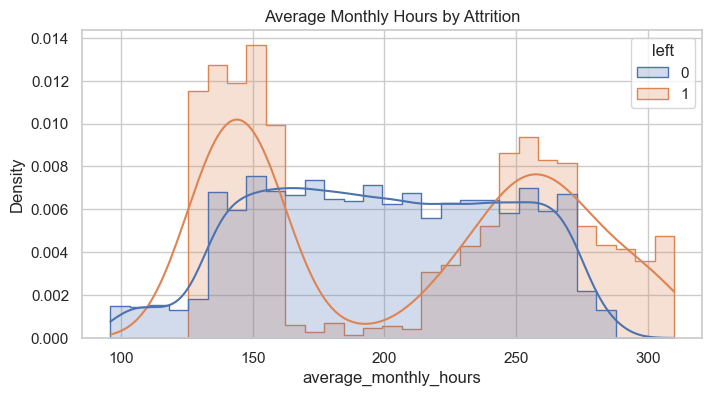

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="average_monthly_hours", hue="left", kde=True, element="step", stat="density", common_norm=False)
plt.title("Average Monthly Hours by Attrition")
plt.show()

### 6.2 Tenure vs attrition

Tenure (`time_spend_company`) is often associated with “career plateau” risk: attrition can rise after several years without growth.


In [17]:
tenure_summary = (
    df.groupby("time_spend_company")["left"]
      .agg(attrition_rate="mean", n="size")
      .reset_index()
      .sort_values("time_spend_company")
)
tenure_summary

,time_spend_company,attrition_rate,n
0,2,0.010653,2910
1,3,0.168401,5190
2,4,0.246883,2005
3,5,0.453861,1062
4,6,0.201107,542
5,7,0.000000,94
6,8,0.000000,81
7,10,0.000000,107


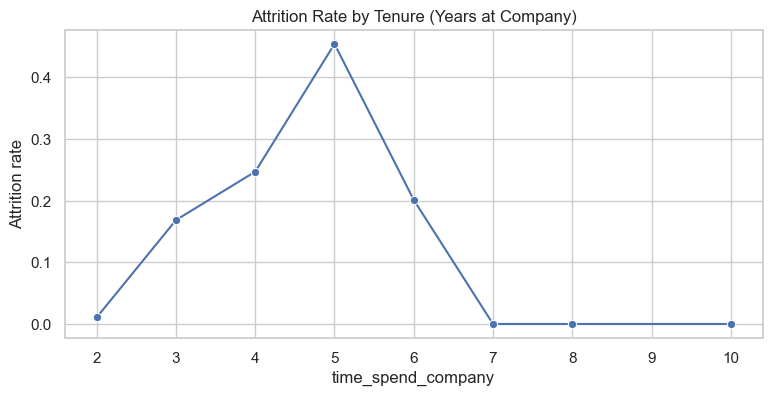

In [18]:
plt.figure(figsize=(9, 4))
sns.lineplot(data=tenure_summary, x="time_spend_company", y="attrition_rate", marker="o")
plt.title("Attrition Rate by Tenure (Years at Company)")
plt.ylabel("Attrition rate")
plt.show()

## 7) Correlation heatmap (numeric features only)

`df.corr()` fails if the dataframe contains strings (department, salary).
The safe approach is:

```python
df.select_dtypes(include="number").corr(numeric_only=True)
```

Also note: correlation measures **linear** relationships only.


In [19]:
corr = df.select_dtypes(include="number").corr(numeric_only=True)

# Show correlations with the target
corr["left"].sort_values()

satisfaction_level      -0.350558
Work_accident           -0.125436
promotion_last_5years   -0.044657
last_evaluation          0.013520
number_project           0.030928
average_monthly_hours    0.070409
time_spend_company       0.173295
left                     1.000000
Name: left, dtype: float64

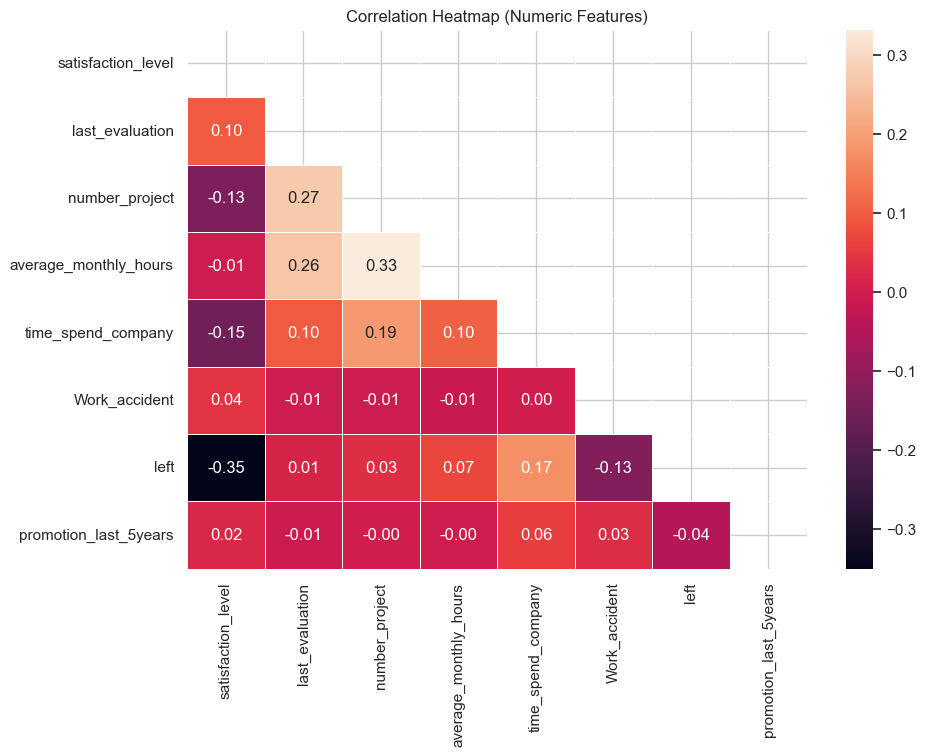

In [20]:
plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 8) Interaction view: satisfaction × evaluation heatmap

Sometimes one feature only becomes interesting **in combination** with another.
We bin:
- `satisfaction_level` into 10 quantiles
- `last_evaluation` into 10 quantiles

Then compute the mean attrition rate inside each cell.


In [21]:
sat_bin = pd.qcut(df["satisfaction_level"], q=10, duplicates="drop")
eval_bin = pd.qcut(df["last_evaluation"], q=10, duplicates="drop")

pivot = df.pivot_table(
    index=sat_bin,
    columns=eval_bin,
    values="left",
    aggfunc="mean",
    observed=False,   # explicit to avoid FutureWarnings across pandas versions
)

pivot.iloc[:3, :3]

last_evaluation,"(0.359, 0.5]","(0.5, 0.54]","(0.54, 0.59]"
satisfaction_level,,,
"(0.089, 0.24]",0.034091,0.00000,0.111111
"(0.24, 0.43]",0.645702,0.84188,0.720812
"(0.43, 0.52]",0.360000,0.45679,0.309211


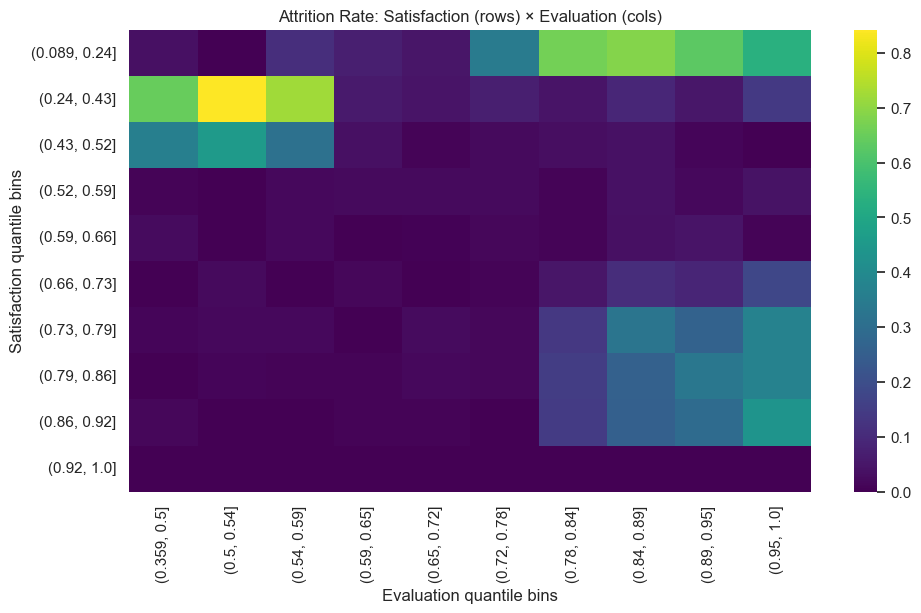

In [22]:
plt.figure(figsize=(11, 6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Attrition Rate: Satisfaction (rows) × Evaluation (cols)")
plt.xlabel("Evaluation quantile bins")
plt.ylabel("Satisfaction quantile bins")
plt.show()

## 9) Simple, explainable feature engineering

To make the insights more “business readable,” we can create simple flags like:
- `overworked`: >= 250 monthly hours
- `underworked`: <= 150 monthly hours
- `high_projects`: >= 6 projects
- `low_projects`: <= 2 projects
- `long_tenure`: >= 5 years

These thresholds are heuristic, but they help communicate risks clearly.


In [23]:
df_fe = df.copy()

df_fe["overworked"]    = (df_fe["average_monthly_hours"] >= 250).astype(int)
df_fe["underworked"]   = (df_fe["average_monthly_hours"] <= 150).astype(int)
df_fe["high_projects"] = (df_fe["number_project"] >= 6).astype(int)
df_fe["low_projects"]  = (df_fe["number_project"] <= 2).astype(int)
df_fe["long_tenure"]   = (df_fe["time_spend_company"] >= 5).astype(int)

flag_cols = ["overworked", "underworked", "high_projects", "low_projects", "long_tenure"]

flag_rates = (
    pd.concat(
        [(df_fe.groupby(c, observed=True)["left"].mean().rename(c)) for c in flag_cols],
        axis=1
    )
)

flag_rates

,overworked,underworked,high_projects,low_projects,long_tenure
0,0.133761,0.143641,0.133848,0.108944,0.138545
1,0.289273,0.259021,0.531411,0.541719,0.313362


## 10) Bucket satisfaction into Low / Medium / High (business-friendly)

Instead of a row-wise `.apply(...)` (slow), use a vectorized approach with `pd.cut`:

- Low: < 0.5  
- Medium: 0.5–0.8  
- High: > 0.8

Then compute attrition rate per bucket.


In [24]:
df_fe["Sat"] = pd.cut(
    df_fe["satisfaction_level"],
    bins=[0, 0.5, 0.8, 1.0],
    labels=["Low", "Medium", "High"],
    include_lowest=True
)

sat_bucket_rate = df_fe.groupby("Sat", observed=True)["left"].mean()
sat_bucket_rate

Sat
Low       0.417849
Medium    0.051662
High      0.091263
Name: left, dtype: float64

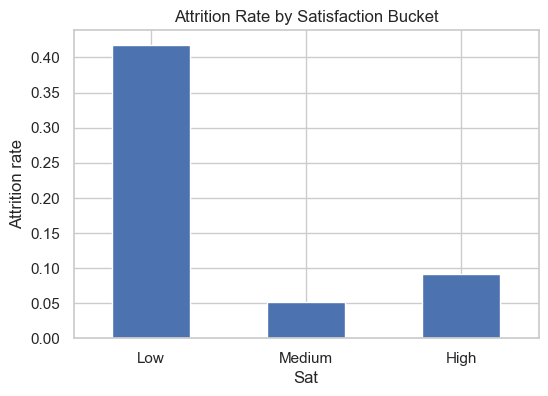

In [25]:
plt.figure(figsize=(6, 4))
ax = sat_bucket_rate.plot(kind="bar")
ax.set_ylabel("Attrition rate")
ax.set_title("Attrition Rate by Satisfaction Bucket")
plt.xticks(rotation=0)
plt.show()

## 11) Predictive baseline models 

Even if your main goal is EDA, a model can answer:
- *Do these features meaningfully predict attrition?*
- *Which signals matter most?*

We’ll build two models:

1. **Logistic Regression** (interpretable, linear baseline)  
2. **Random Forest** (captures non-linear patterns like the project-count extremes)

### 11.1 Train/test split
We stratify on `left` so the train and test sets have similar class balance.


In [26]:
X = df.drop(columns=["left"])
y = df["left"]

num_features = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "time_spend_company",
    "Work_accident",
    "promotion_last_5years",
]
cat_features = ["department", "salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

y_train.mean(), y_test.mean()

(np.float64(0.16607589658048375), np.float64(0.16590245935806586))

### 11.2 Logistic Regression pipeline

We build a pipeline that:
- Standardizes numeric columns
- One-hot encodes categorical columns
- Fits a logistic regression model

We evaluate using:
- **ROC-AUC** (ranking quality)
- **PR-AUC** (more informative with class imbalance)


In [27]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_features),
    ]
)

log_model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000)),
    ]
)

log_model.fit(X_train, y_train)

log_proba = log_model.predict_proba(X_test)[:, 1]
log_roc = roc_auc_score(y_test, log_proba)
log_pr = average_precision_score(y_test, log_proba)

log_roc, log_pr

(0.8422308946029498, 0.43691981888172043)

#### Interpreting coefficients

For standardized numeric features:
- Positive coefficient → higher attrition risk
- Negative coefficient → lower attrition risk

For one-hot encoded categories:
- Coefficients are relative to the dropped reference category (alphabetical baseline after `drop='first'`)

Below we list the strongest positive and negative coefficients.


In [28]:
feature_names = log_model.named_steps["prep"].get_feature_names_out()
coefs = log_model.named_steps["clf"].coef_[0]

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .sort_values("coef", ascending=False)
)

display(coef_df.head(10))
display(coef_df.tail(10))

,feature,coef
16,cat__salary_low,1.871040
17,cat__salary_medium,1.443353
4,num__time_spend_company,0.430624
3,num__average_monthly_hours,0.201453
1,num__last_evaluation,0.123373
9,cat__department_hr,0.106037
15,cat__department_technical,0.100935
13,cat__department_sales,0.082142
8,cat__department_accounting,0.073681
14,cat__department_support,0.063931


,feature,coef
8,cat__department_accounting,0.073681
14,cat__department_support,0.063931
11,cat__department_marketing,0.038129
12,cat__department_product_mng,-0.069059
6,num__promotion_last_5years,-0.156950
10,cat__department_management,-0.212071
2,num__number_project,-0.318472
7,cat__department_RandD,-0.413031
5,num__Work_accident,-0.497609
0,num__satisfaction_level,-0.927002


### 11.3 Random Forest (non-linear model)

Random forests can capture patterns that logistic regression misses, such as:
- high attrition for **very low** project counts
- high attrition for **very high** project counts

To make the forest work smoothly, we’ll one-hot encode categories into a **dense** matrix
(the feature space is small here, so dense is fine).


In [29]:
preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), cat_features),
    ]
)

rf_model = Pipeline(
    steps=[
        ("prep", preprocess_dense),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )),
    ]
)

rf_model.fit(X_train, y_train)

rf_proba = rf_model.predict_proba(X_test)[:, 1]
rf_roc = roc_auc_score(y_test, rf_proba)
rf_pr = average_precision_score(y_test, rf_proba)

rf_roc, rf_pr

(0.978612452567686, 0.963939537587861)

#### Random Forest feature importances

Feature importances are not causal, but they help validate:
- Which variables the model relies on most
- Whether the result matches EDA intuition


In [30]:
rf_feat_names = rf_model.named_steps["prep"].get_feature_names_out()
rf_importances = rf_model.named_steps["clf"].feature_importances_

imp_df = (
    pd.DataFrame({"feature": rf_feat_names, "importance": rf_importances})
      .sort_values("importance", ascending=False)
)

imp_df.head(15)

,feature,importance
0,num__satisfaction_level,0.281371
4,num__time_spend_company,0.236399
2,num__number_project,0.152779
3,num__average_monthly_hours,0.145058
1,num__last_evaluation,0.138488
5,num__Work_accident,0.010416
16,cat__salary_low,0.007470
17,cat__salary_medium,0.004330
13,cat__department_sales,0.004282
15,cat__department_technical,0.003846


## 12) Key insights (what we learned)

From the improved EDA + modeling:

- **Satisfaction** is the strongest single signal: lower satisfaction is strongly associated with higher attrition.
- **Workload is non-linear**: extreme project counts (≤2 or ≥6) and extreme monthly hours are high-risk segments.
- **Tenure matters**: attrition tends to increase for longer-tenured employees (possible plateau effect).
- **Salary bands** show clear differences in attrition rates (low > medium > high).
- Some signals (like evaluation score) matter less on their own, but can matter in **interaction** with satisfaction/workload.

---

## 13) Recommendations (actionable, data-driven)

If you’re an HR partner, a practical way to use these results is **triage**:

1) **Retention conversations for low satisfaction employees**  
   - Prioritize those with `satisfaction_level < 0.5`

2) **Workload balancing**
   - Investigate employees with very low (`<=2`) or very high (`>=6`) project counts  
   - Review extreme hours (`<=150` or `>=250` monthly)

3) **Career growth and mobility**
   - Focus on employees with `time_spend_company >= 5` and no promotion in 5 years

4) **Compensation benchmarking**
   - Higher attrition in low salary bands suggests market/level alignment checks

---

## 14) Limitations and ethics

- The dataset is synthetic/training-oriented; real HR data is noisier and can contain measurement bias.
- Predictions should *not* be used to penalize employees.
- Use analytics to **support** people managers and improve working conditions (workload, growth, pay equity).
